In [7]:
import numpy as np
import pandas as pd
import time
import os
import pathlib

import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras import losses, optimizers
from tensorflow.keras.models import Sequential, load_model
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Input, Activation, Dense, TimeDistributed,Conv2D,MaxPooling2D, Lambda,UpSampling2D
from tensorflow.keras.layers import add, dot, concatenate, LSTM, Bidirectional,Reshape,Flatten
import tensorflow.keras as keras
from tensorflow.compat.v1.keras.layers import CuDNNLSTM, CuDNNGRU
#from tf.compat.v1.keras.layers.CuDNNLSTM
from Utils.PlotLosses import PlotLosses
from Utils.Utils import dist_coordinates, TrainModel, s_DataFrame, s_relative_and_std, euclidean_distance_loss,set_input

K.clear_session()

## Methods

In [8]:
def model_LSTM(size = []) :
    K.clear_session()
    
    history_input = Input(shape=(size[0]))
    observed_input = Input(shape=(size[1],))
    
    history_hidden1 = Bidirectional(LSTM(size[2], return_sequences = False),name ='History_Hidden1')(history_input)
    
    observed_hidden1 = Dense(size[3],activation='relu',name = 'Observer_Hidden1')(observed_input)
    observed_hidden2 = Dense(size[4],activation='relu',name = 'Observer_Hidden2')(observed_hidden1)
    
    concat_1 = concatenate([history_hidden1,observed_hidden2],axis = -1, name = 'Concatenate')
    
    hidden1 = Dense(size[5], activation = 'relu', name = 'Concat-Hidden1')(concat_1)
    
    hidden2_1 = Dense(size[6], activation = 'relu', name = 'Conat-Hidden2_1')(hidden1)
    hidden2_2 = Dense(size[6], activation = 'relu', name = 'Conat-Hidden2_2')(hidden1)
    
    y_head = Dense(size[7], activation = 'tanh',name='Output_head')(hidden2_1) 
    y_orientation = Dense(size[8],activation = 'tanh',name='Output_orientation')(hidden2_2)

    _model = keras.Model(inputs=[history_input, observed_input], outputs=[y_head,y_orientation])
    print(_model.summary())
    
    return _model

In [9]:
def s_labels(_label_list=[],data='') :
    y_label = list()
    for i in range(0,len(_label_list)) :
        y_data = s_DataFrame(index = _label_list[i],data = data)
        y_label.append(y_data)
    return y_label

## inputs

In [15]:
std_coordinates = 500
std_orientation = 180

_n_hist = 10
_n_samples = 12

In [11]:
path = './Data_v2.0/3Robots/TrainSet'
data_train = pd.read_csv(path+'/Train.csv')
data_test = pd.read_csv(path+'/Test.csv')
data_val = pd.read_csv(path+'/Val.csv')

robots = ['H','F1','T']
std_robot = 'T'
coordinates = ['x','y']
orientation = ['o']


In [12]:
train_data = s_relative_and_std(data = data_train, std_coordinates = std_coordinates,n_time_in_instance=_n_samples,std_robot ='T',other_robots=['H','F1'])
val_data = s_relative_and_std(data = data_val, std_coordinates = std_coordinates,n_time_in_instance=_n_samples,std_robot ='T',other_robots=['H','F1'])
test_data = s_relative_and_std(data = data_test, std_coordinates = std_coordinates,n_time_in_instance=_n_samples,std_robot ='T',other_robots=['H','F1'])

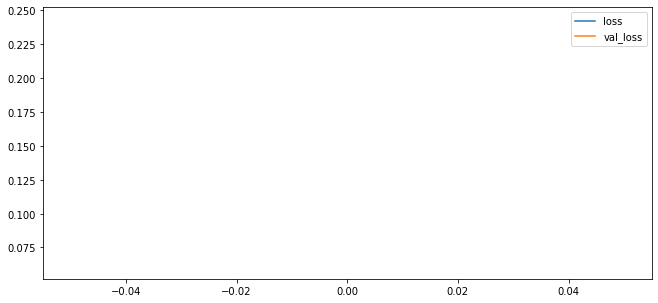


Epoch 00001: val_loss improved from inf to 0.06101, saving model to ./SaveModels/CompareHistory/Model1_hist_2_0.h
10624/10624 [==============================] - 4s 365us/sample - loss: 0.2433 - Output_head_loss: 0.1113 - Output_orientation_loss: 0.1320 - val_loss: 0.0610 - val_Output_head_loss: 0.0250 - val_Output_orientation_loss: 0.0360


In [20]:
_obs_list = ['_F1_x','_F1_y','_T_o']
pred_list = ['_H_x','_H_y','_F1_o','_H_o']

_label_list = [['{}_H_x'.format(_n_hist),'{}_H_y'.format(_n_hist)],
            ['{}_F1_o'.format(_n_hist),'{}_H_o'.format(_n_hist)]]
step = 0

for start in range(0,_n_hist,2) :
    ## Set inputs
    x_train = set_input(_obs_list = _obs_list, start = start, 
                        pred_list= pred_list,step = step, 
                        _hist_len = _n_hist,_n_samples = _n_samples, data1 = train_data,data2 = train_data)
    x_val = set_input(_obs_list = _obs_list, start = start,
                      pred_list= pred_list,step = step,  
                      _hist_len = _n_hist,_n_samples = _n_samples, data1 = val_data,data2 = val_data)
    x_test = set_input(_obs_list = _obs_list, start = start,
                       pred_list= pred_list,step = step,  
                       _hist_len = _n_hist,_n_samples = _n_samples, data1 = test_data,data2 = test_data)
    
    ## Set Labels
    y_train = s_labels(_label_list = _label_list, data = train_data)
    y_val = s_labels(_label_list = _label_list, data = val_data)
    y_test = s_labels(_label_list = _label_list, data = test_data)
    
    ## Training 
    size = [(10-start,7),6,30,10,10,50,30,2,2]
    lr = 0.00025
    epochs = 500
    for i in range(0,5) :
        save_path = './SaveModels/CompareHistory/Model1_hist_{}_{}.h'.format(10-start,i)

        _model1 = model_LSTM(size)
        Model1,history1 = TrainModel(_model = _model1,save_path = save_path, lr = lr,epochs=epochs,
        #                             losses = ['mean_squared_error'],
                                     losses = [euclidean_distance_loss,'mean_squared_error'],
                                     train_x = x_train, train_y =y_train,
                                    val_x = x_val, val_y =y_val )
